In [8]:
import torch

ckpt=torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/enrollment_model_W0.0001_fulldata_sexspecific.pt')

import torch, numpy as np

state = ckpt.get('model_state_dict', ckpt)

phi = state['phi'].cpu().numpy()        # [K, D, T]
psi = state['psi'].cpu().numpy()        # [K, D]
lam = state['lambda_'].cpu().numpy()    # [N, K, T]
disease_names = ckpt.get('disease_names', None)

# quick checks (indices you mentioned)
mi, depr, afib, breast, colon = 112, 67, 127, 17, 0
sig_mi, sig_depr, sig_afib, sig_breast, sig_colon = 5, 7, 0, 19, 17

print(phi[sig_mi, mi].shape, phi[sig_depr, depr].shape, phi[sig_afib, afib].shape)
print(phi[sig_breast, breast].shape, phi[sig_colon, colon].shape)
# e.g., look at timepoint-peak signatures
for d, s in [(mi, sig_mi),(depr, sig_depr),(afib, sig_afib),(breast, sig_breast),(colon, sig_colon)]:
    print(d, s, np.argmax(1/(1+np.exp(-phi[s, d]))))  # peak time index

import numpy as np
from sklearn.metrics import roc_auc_score

# tensors from checkpoint
Y = ckpt['Y'].cpu().numpy()          # [N,D,T] if saved; else use your loaded Y
lam = state['lambda_'].cpu().numpy()  # [N,K,T]

def first_event_time(y_dt):
    idx = np.flatnonzero(y_dt > 0)
    return int(idx[0]) if idx.size else None

def lambda_event_vs_control(d, s):
    N, _, T = Y.shape
    case_idx = np.where(Y[:, d, :].any(axis=1))[0]
    ctrl_idx = np.where(~Y[:, d, :].any(axis=1))[0]
    if case_idx.size == 0 or ctrl_idx.size == 0:
        return np.nan, np.array([]), np.array([])

    # event times for cases (integers)
    t_case_list = [first_event_time(Y[i, d, :]) for i in case_idx]
    # keep only valid (just in case)
    valid = [i for i, t in zip(case_idx, t_case_list) if t is not None]
    t_case = np.array([t for t in t_case_list if t is not None], dtype=np.int64)
    if t_case.size == 0:
        return np.nan, np.array([]), np.array([])

    lam_cases = lam[valid, s, :][np.arange(t_case.size, dtype=np.int64), t_case]

    # controls matched on event-time distribution
    t_match = np.random.choice(t_case, size=ctrl_idx.size, replace=True).astype(np.int64)
    lam_ctrls = lam[ctrl_idx, s, :][np.arange(ctrl_idx.size, dtype=np.int64), t_match]

    y = np.concatenate([np.ones_like(lam_cases), np.zeros_like(lam_ctrls)])
    x = np.concatenate([lam_cases, lam_ctrls])
    return roc_auc_score(y, x), lam_cases, lam_ctrls

# examples (disease→signature)
pairs = [(112,5), (67,7), (127,0), (17,19), (10,17)]
for d,s in pairs:
    auc, _, _ = lambda_event_vs_control(d,s)
    print(f"Disease {d}, sig {s} | AUROC(λ@event): {auc:.3f}")


(52,) (52,) (52,)
(52,) (52,)
112 5 41
67 7 43
127 0 38
17 19 33
0 17 31
Disease 112, sig 5 | AUROC(λ@event): 0.950
Disease 67, sig 7 | AUROC(λ@event): 0.868
Disease 127, sig 0 | AUROC(λ@event): 0.832
Disease 17, sig 19 | AUROC(λ@event): 0.964
Disease 10, sig 17 | AUROC(λ@event): 0.934


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_38986/3437790980.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load('/Users/sarahurbut/Library/Cl

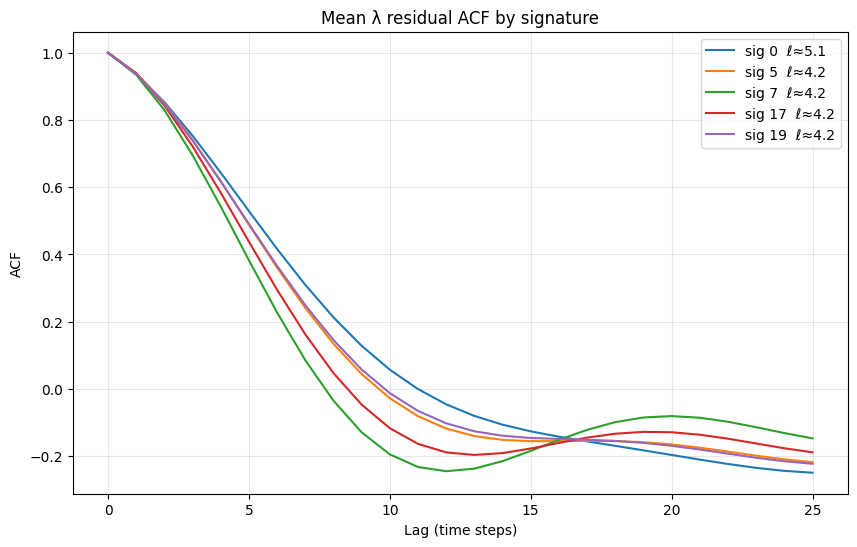

Signature 0: estimated λ length-scale ≈ 5.10 steps
Signature 5: estimated λ length-scale ≈ 4.25 steps
Signature 7: estimated λ length-scale ≈ 4.25 steps
Signature 17: estimated λ length-scale ≈ 4.25 steps
Signature 19: estimated λ length-scale ≈ 4.25 steps


In [9]:
# === λ residual ACF and length-scale check ===
import numpy as np
import matplotlib.pyplot as plt

# Required: lam [N,K,T], Y [N,D,T]
# Optional: G [N,P], gamma [P,K], signature_refs [K,T]
# If G/gamma/signature_refs are missing, the code falls back gracefully.

def acf_1d(x, maxlag=25):
    x = x - x.mean()
    c = np.correlate(x, x, mode='full')
    c = c[c.size//2:]
    c /= (c[0] + 1e-12)
    return c[:maxlag+1]

def estimate_length_scale_from_acf(acf):
    # Fit SE kernel ACF ~ exp(-0.5*(dt/ℓ)^2) using half-maximum
    # find first lag where acf <= 0.5
    idx = np.where(acf <= 0.5)[0]
    if idx.size == 0:
        return np.inf
    dt = idx[0]
    return dt / np.sqrt(2*np.log(2))

def residualize_lambda(lam_sig, signature_ref=None, G=None, gamma_k=None):
    # lam_sig: [N,T]
    resid = lam_sig.copy()

    # remove genetics if available
    if (G is not None) and (gamma_k is not None):
        gen = G @ gamma_k  # [N]
        resid = resid - gen[:, None]

    # remove population time-varying mean (signature_refs if given, else mean over N)
    if signature_ref is not None:
        resid = resid - signature_ref[None, :]
    else:
        resid = resid - resid.mean(axis=0, keepdims=True)

    return resid

def acf_and_lengthscale_for_signature(sig, maxlag=25):
    lam_sig = lam[:, sig, :]  # [N,T]

    # pull optional pieces if present in notebook
    G_here = G if 'G' in globals() else None
    gamma_here = gamma[:, sig] if ('gamma' in globals()) else None
    sigref_here = signature_refs[sig] if ('signature_refs' in globals()) else None

    resid = residualize_lambda(lam_sig, signature_ref=sigref_here, G=G_here, gamma_k=gamma_here)

    # average ACF across individuals
    acfs = np.stack([acf_1d(resid[i], maxlag=maxlag) for i in range(resid.shape[0])])
    acf_mean = acfs.mean(axis=0)
    ell = estimate_length_scale_from_acf(acf_mean)
    return acf_mean, ell

# Run for the signatures in your pairs
sigs = [s for (_, s) in pairs]
unique_sigs = sorted(set(sigs))

plt.figure(figsize=(10, 6))
for s in unique_sigs:
    acf_mean, ell = acf_and_lengthscale_for_signature(s, maxlag=25)
    plt.plot(acf_mean, label=f"sig {s}  ℓ≈{ell:.1f}")
plt.xlabel("Lag (time steps)")
plt.ylabel("ACF")
plt.title("Mean λ residual ACF by signature")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print a tidy table
for s in unique_sigs:
    acf_mean, ell = acf_and_lengthscale_for_signature(s, maxlag=25)
    print(f"Signature {s}: estimated λ length-scale ≈ {ell:.2f} steps")

Volatility (σ): cases=0.2056, ctrls=0.0664, Δ=0.1393, U p=7.82e-215, t p=4.77e-68
Total variation: cases=0.1316, ctrls=0.0390, Δ=0.0926, U p=9.61e-261, t p=5.60e-97


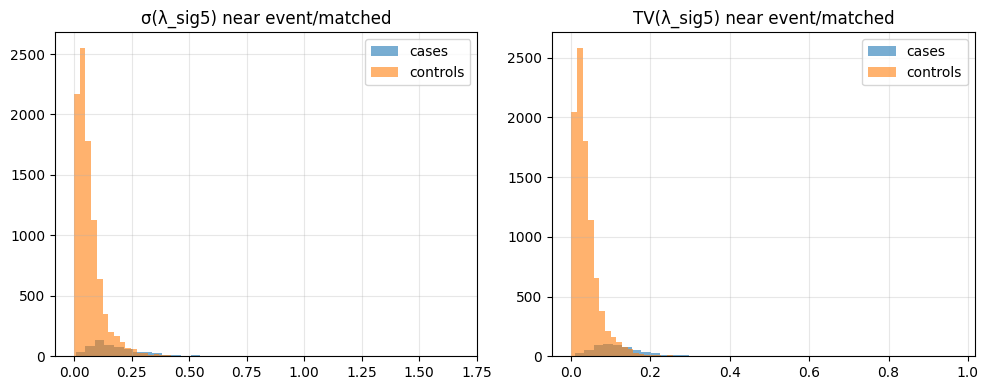

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

d, s = 112, 5
N, K, T = lam.shape

def first_event_time(y_dt):
    idx = np.flatnonzero(y_dt > 0)
    return int(idx[0]) if idx.size else None

case_idx = np.where(Y[:, d, :].any(axis=1))[0]
ctrl_idx = np.where(~Y[:, d, :].any(axis=1))[0]
t_case = np.array([first_event_time(Y[i, d, :]) for i in case_idx], dtype=object)
valid = np.array([t is not None for t in t_case])
case_idx = case_idx[valid]
t_case = t_case[valid].astype(np.int64)

# fixed-length window via clipped indices
win = 6              # total width; use even number
half = win // 2
def fixed_idx(t):
    idx = np.arange(t - half, t + half)  # length == win
    return np.clip(idx, 0, T - 1).astype(np.int64)

lam_cases_win = np.stack([lam[i, s, fixed_idx(t)] for i, t in zip(case_idx, t_case)])
# match control times to case event-time distribution
t_match = np.random.choice(t_case, size=ctrl_idx.size, replace=True).astype(np.int64)
lam_ctrls_win = np.stack([lam[i, s, fixed_idx(t)] for i, t in zip(ctrl_idx, t_match)])

# metrics (same length => no stacking error)
vol_cases = lam_cases_win.std(axis=1)
vol_ctrls = lam_ctrls_win.std(axis=1)
tv_cases = np.mean(np.abs(np.diff(lam_cases_win, axis=1)), axis=1)
tv_ctrls = np.mean(np.abs(np.diff(lam_ctrls_win, axis=1)), axis=1)

def summarize(name, cases, ctrls):
    u_p = mannwhitneyu(cases, ctrls, alternative='greater').pvalue
    t_p = ttest_ind(cases, ctrls, equal_var=False, alternative='greater').pvalue
    print(f"{name}: cases={cases.mean():.4f}, ctrls={ctrls.mean():.4f}, "
          f"Δ={cases.mean()-ctrls.mean():.4f}, U p={u_p:.2e}, t p={t_p:.2e}")

summarize("Volatility (σ)", vol_cases, vol_ctrls)
summarize("Total variation", tv_cases, tv_ctrls)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(vol_cases, bins=40, alpha=0.6, label='cases')
axes[0].hist(vol_ctrls, bins=40, alpha=0.6, label='controls')
axes[0].set_title(f"σ(λ_sig{s}) near event/matched"); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].hist(tv_cases, bins=40, alpha=0.6, label='cases')
axes[1].hist(tv_ctrls, bins=40, alpha=0.6, label='controls')
axes[1].set_title(f"TV(λ_sig{s}) near event/matched"); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

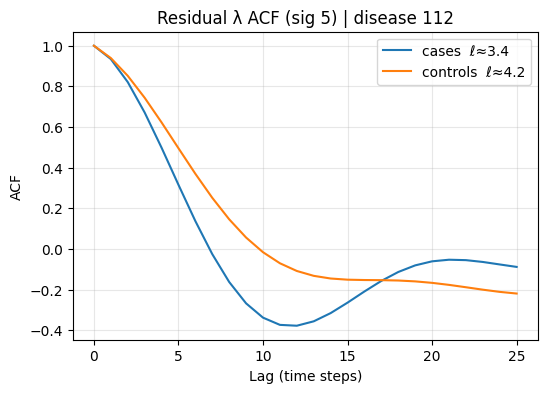

sig 5, disease 112: ℓ_cases≈3.40, ℓ_controls≈4.25


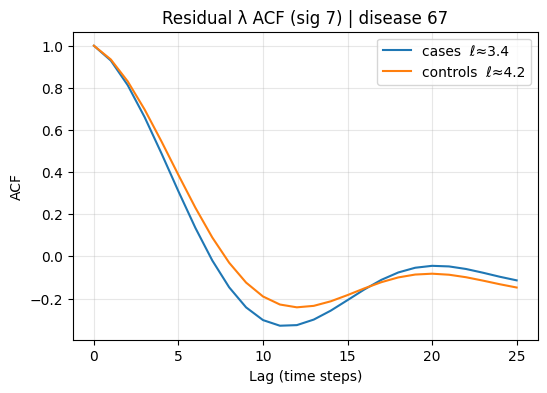

sig 7, disease 67: ℓ_cases≈3.40, ℓ_controls≈4.25


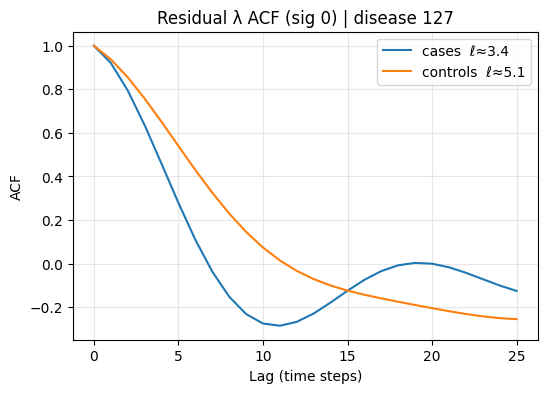

sig 0, disease 127: ℓ_cases≈3.40, ℓ_controls≈5.10


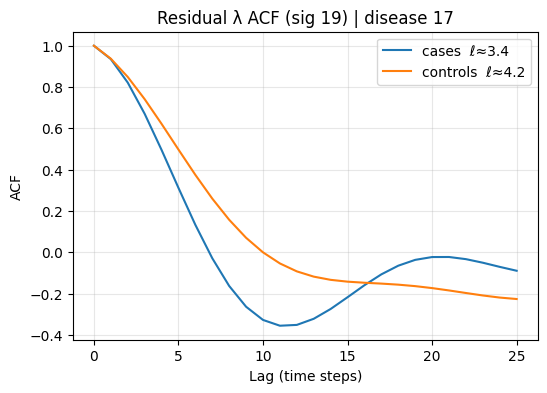

sig 19, disease 17: ℓ_cases≈3.40, ℓ_controls≈4.25


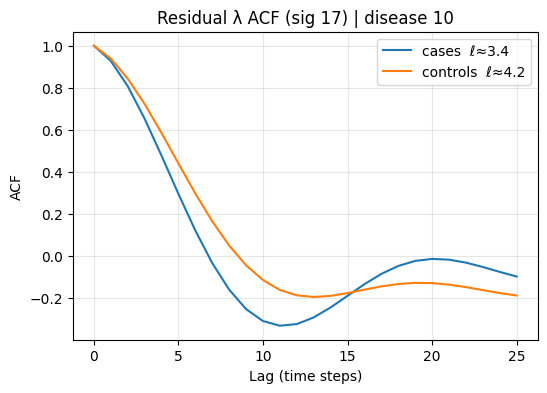

sig 17, disease 10: ℓ_cases≈3.40, ℓ_controls≈4.25


In [13]:
# Compare residual λ ACF for cases vs controls
def acf_group(sig, disease, maxlag=25):
    # group membership
    case_idx = np.where(Y[:, disease, :].any(axis=1))[0]
    ctrl_idx = np.where(~Y[:, disease, :].any(axis=1))[0]

    def group_acf(idxs):
        lam_sig = lam[idxs, sig, :]  # [n,T]
        G_here = G[idxs] if ('G' in globals()) else None
        gamma_here = gamma[:, sig] if ('gamma' in globals()) else None
        sigref_here = signature_refs[sig] if ('signature_refs' in globals()) else None
        resid = residualize_lambda(lam_sig, signature_ref=sigref_here, G=G_here, gamma_k=gamma_here)
        acfs = np.stack([acf_1d(resid[i], maxlag=maxlag) for i in range(resid.shape[0])])
        mean_acf = acfs.mean(axis=0)
        ell = estimate_length_scale_from_acf(mean_acf)
        return mean_acf, ell

    acf_cases, ell_cases = group_acf(case_idx)
    acf_ctrls, ell_ctrls = group_acf(ctrl_idx)

    # plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.plot(acf_cases, label=f'cases  ℓ≈{ell_cases:.1f}')
    plt.plot(acf_ctrls, label=f'controls  ℓ≈{ell_ctrls:.1f}')
    plt.xlabel('Lag (time steps)'); plt.ylabel('ACF')
    plt.title(f'Residual λ ACF (sig {sig}) | disease {disease}')
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    print(f"sig {sig}, disease {disease}: ℓ_cases≈{ell_cases:.2f}, ℓ_controls≈{ell_ctrls:.2f}")
    return (acf_cases, ell_cases), (acf_ctrls, ell_ctrls)

# Example: MI/sig5, Depression/sig7, AFib/sig0, Breast/sig19, Colon/sig17
for d,s in [(112,5),(67,7),(127,0),(17,19),(10,17)]:
    acf_group(s, d, maxlag=25)

With a smooth prior (long length‑scale) you can still learn “wiggly” trajectories as long as its weight is weak (small W). The likelihood overrides the prior where signal is strong (near events), so λ can change fast; the prior mainly stabilizes low‑signal regions. If you make the prior forceful (large W), you risk oversmoothing. Your ACF/λ@event results show the balance is working.

In [14]:
ckpt.keys()

dict_keys(['model_state_dict', 'phi', 'Y', 'prevalence_t', 'logit_prevalence_t', 'G'])

In [16]:
ckpt['model_state_dict'].keys()

odict_keys(['kappa', 'gamma', 'lambda_', 'phi', 'psi'])